In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder
import glob

In [2]:
tifs = sorted(glob.glob(raw_folder + '/*.tif'))
print('no of tifs: {}'.format(len(tifs)))

no of tifs: 1


In [3]:
import SimpleITK as sitk

In [4]:
image_index = 0
tif_path = tifs[image_index]
image = sitk.ReadImage(tif_path)
nda = sitk.GetArrayFromImage(image)

In [5]:
import pandas as pd

In [6]:
labels = glob.glob(raw_folder + '/' + os.path.basename(tif_path).split('.')[0] + '_label_*.nrrd')
print('no of labels: {}'.format(len(labels)))

no of labels: 1


In [7]:
label_index = 0
label_path = labels[label_index]
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)

In [8]:
roi_path = label_path.replace('.nrrd', '_roi.acsv')

In [9]:
roi = np.zeros((2,2))
i = 0
with open(roi_path) as f:
    for line in f.readlines():
        if line.startswith('point'):
            p = line.split('|')
            roi[i,0] = -float(p[1])
            roi[i,1] = -float(p[2])
            i += 1

In [10]:
center = list(roi[0])
center = np.asarray(image.TransformPhysicalPointToIndex(center))
spacing = image.GetSpacing()
length = np.abs(roi[1]/spacing).astype(np.int)
start = center - length
end = center + length
print(start,end)

[19164  2117] [21168  4121]


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

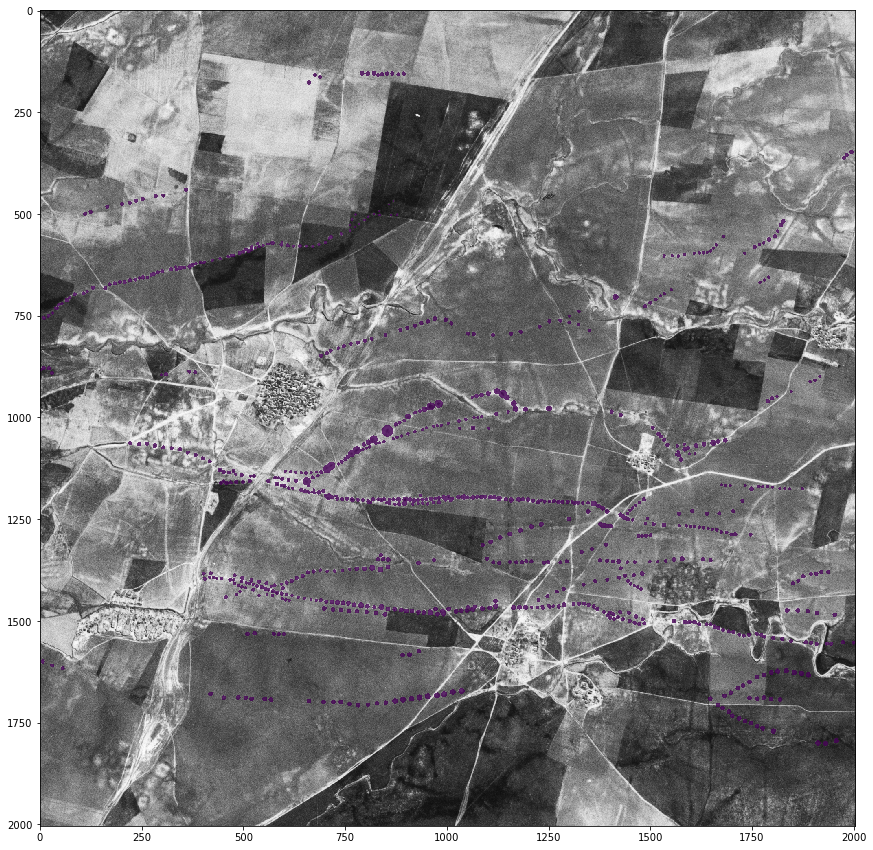

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.8)

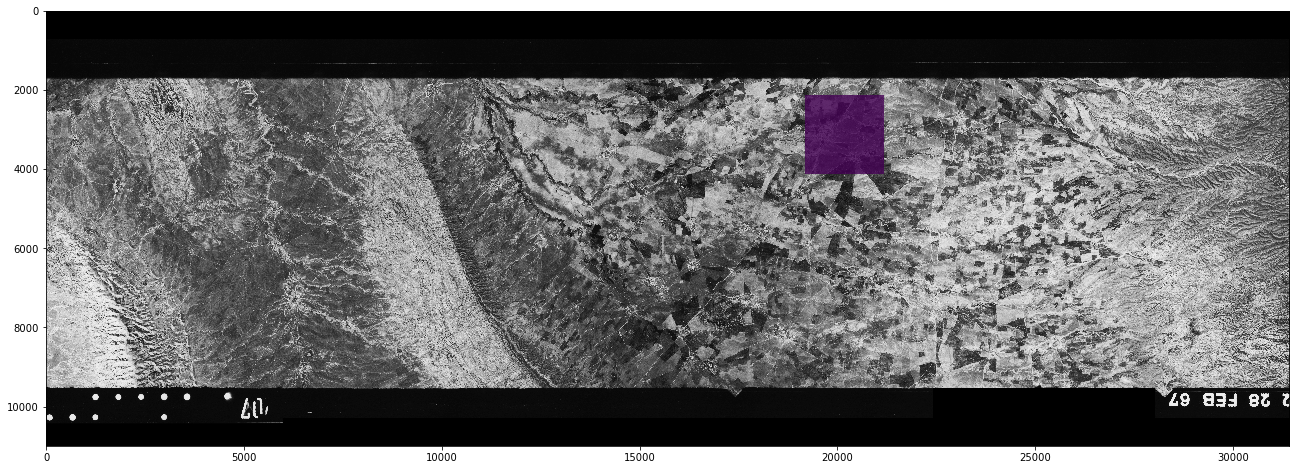

In [13]:
plt.figure(figsize=(24,8))
annotation_area = np.zeros_like(nda)
annotation_area[start[1]:end[1], start[0]:end[0]] = 255
annotation_area = np.ma.masked_where(annotation_area== 0, annotation_area)
plt.imshow(nda, cmap=plt.cm.gray)
plt.imshow(annotation_area, alpha=0.8)

In [13]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
ccf_labelmap = ccf.Execute(label)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(ccf_labelmap, ccf_labelmap)
labels = list(stats_filter.GetLabels())
labels.remove(0)
print(len(labels))

619


In [14]:
changeFilter = sitk.ChangeLabelImageFilter()
changeMap = sitk.DoubleDoubleMap()
for label_val in labels:
    changeMap[label_val] = int(np.random.randint(0,255,1)[0])
ccf_labelmap_random = changeFilter.Execute(ccf_labelmap, changeMap)

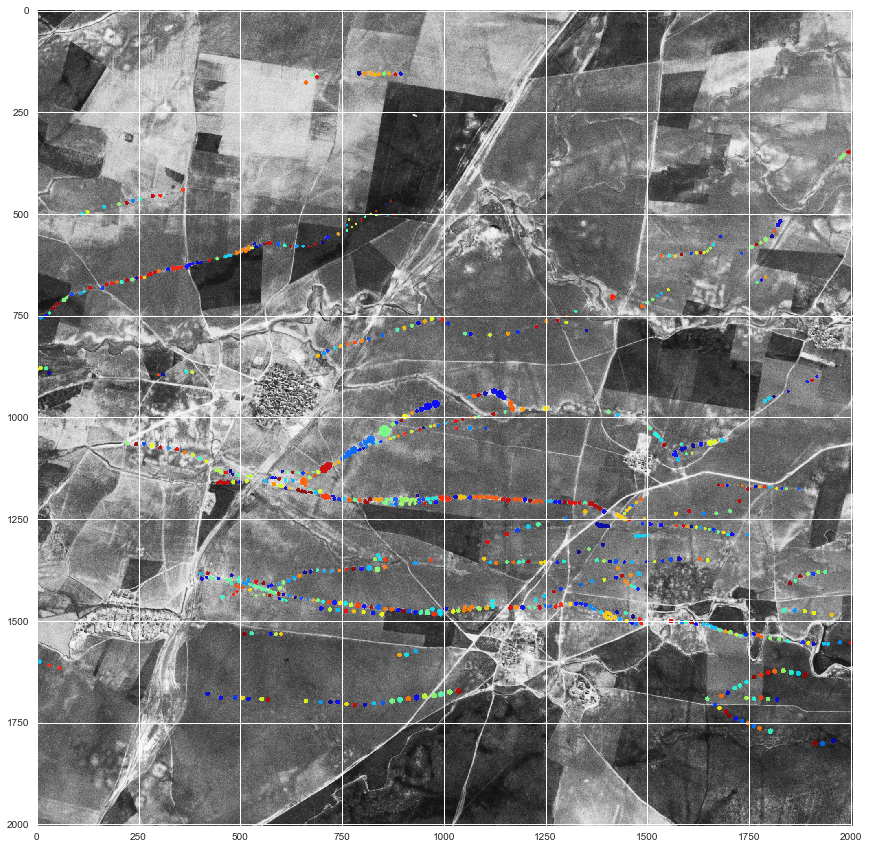

In [15]:
import seaborn as sns
plt.figure(figsize=(15,15))
label_nda = sitk.GetArrayFromImage(ccf_labelmap_random).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.9,cmap=plt.cm.jet)

In [16]:
d = []
pd.DataFrame(d)
for label_value in labels:
    bb = np.asarray(stats_filter.GetBoundingBox(label_value))
    d.append({'label': label_value, 'count': stats_filter.GetCount(label_value), 'x': int( bb[0] + (bb[1]-bb[0])/2), 
              'y': int(bb[2] + (bb[3]-bb[2])/2)}) 

In [17]:
df = pd.DataFrame(d)

In [24]:
largest = df.sort_values('count', ascending=False).head(25)
smallest = df.sort_values('count', ascending=True).head(25)
largest

count  label      x     y
618   3028    619   5079  4846
160    786    161  20127  3089
213    665    214  19930  3206
183    645    184  20017  3150
194    628    195  19973  3177
284    623    285  20075  3323
151    608    152  20298  3060
227    566    228  19873  3240
515    456    516  20571  3604
56     405     57  19668  2705
309    380    310  20534  3334
280    364    281  20165  3316
330    357    331  20552  3381
245    351    246  19818  3276
480    348    481  20221  3587
281    333    282  20280  3315
161    330    162  20329  3089
532    314    533  20815  3630
351    309    352  20648  3407
283    304    284  20133  3319
325    302    326  20598  3361
270    297    271  19820  3298
249    277    250  19620  3276
274    277    275  19873  3312
292    264    293  20024  3323

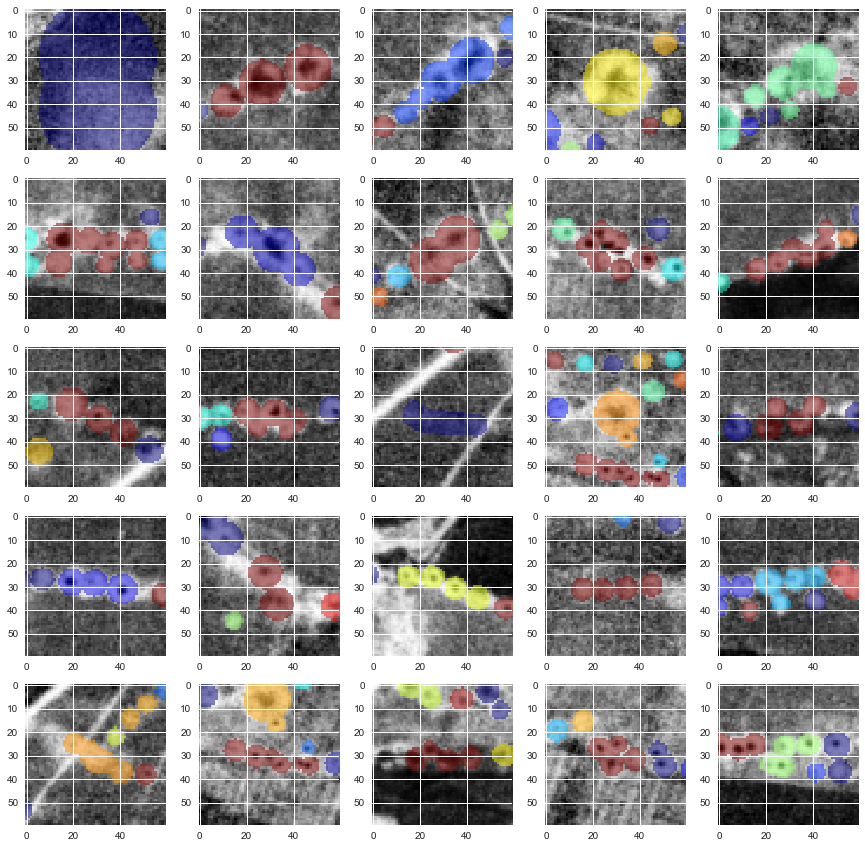

In [55]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
pad = 30
axs = axs.ravel()
i = 0
for index, row in largest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=0.5, cmap=plt.cm.jet)
    i +=1

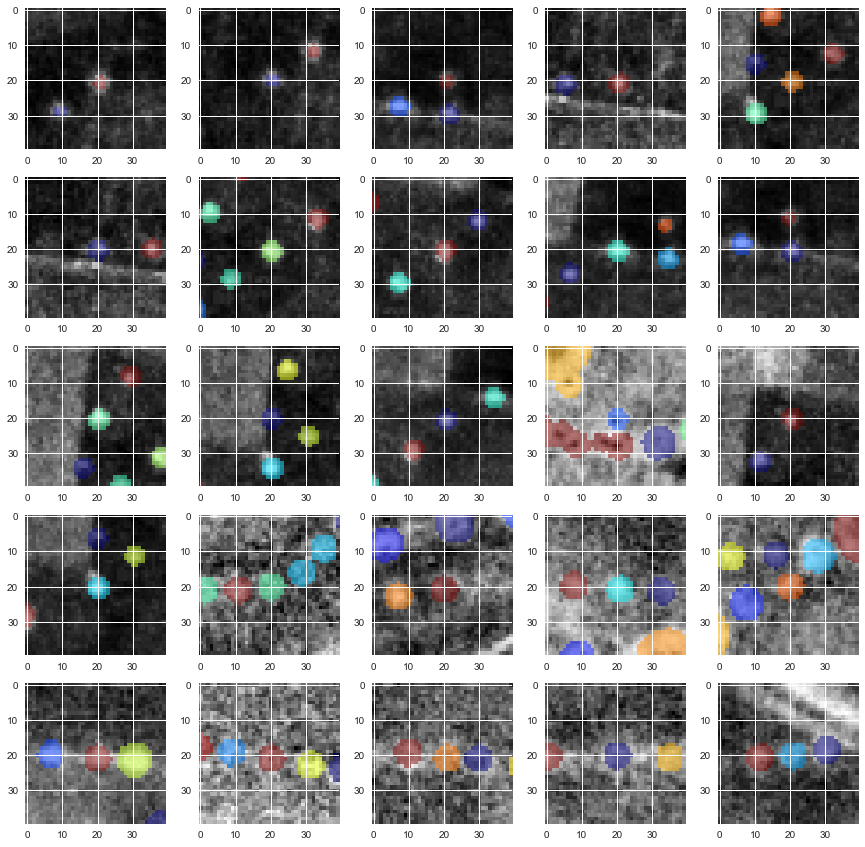

In [26]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
pad = 20
axs = axs.ravel()
i = 0
for index, row in smallest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=0.5, cmap=plt.cm.jet)
    i +=1

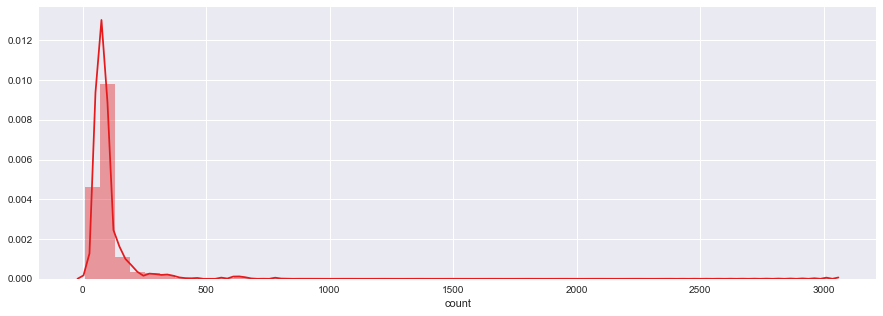

In [53]:
tmp_df = df[df.label != 618] # this is based on random ...
plt.figure(figsize=(15, 5))
sns.distplot(tmp_df['count'])

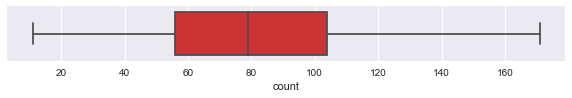

In [36]:
plt.figure(figsize=(10, 1))
sns.boxplot(df['count'],showfliers=False)

In [51]:
df[df.label != 1]

count  label      x     y
1      261      2  19993  2273
2      104      3  19968  2273
3       79      4  20016  2272
4       80      5  20028  2272
5       81      6  20056  2272
6       78      7  20043  2274
7       78      8  19838  2275
8       78      9  19851  2281
9      102     10  19824  2294
10      80     11  21156  2465
11     158     12  21141  2476
12      79     13  19522  2557
13      79     14  19466  2572
14      79     15  19447  2573
15      77     16  19415  2580
16      79     17  19398  2584
17      11     18  20031  2585
18      79     19  19383  2589
19      77     20  19365  2592
20      12     21  20020  2594
21      78     22  19328  2599
22      78     23  19287  2611
23      13     24  19996  2610
24      80     25  19274  2616
25      29     26  19983  2617
26      30     27  19938  2618
27      28     28  20040  2618
28      29     29  19997  2619
29      28     30  20025  2619
30      29     31  19969  2623
..     ...    ...    ...   ...
589    103    590  19683  3808
590    161    591  20054  3810
591    111    592  19715  3809
592    100    593  20959  3809
593    104    594  19730  3810
594    104    595  20981  3810
595    161    596  20035  3813
596    101    597  19823  3814
597    100    598  19860  3816
598    104    599  19883  3816
599    112    600  19902  3816
600    103    601  20012  3817
601    103    602  19991  3819
602    104    603  19924  3821
603    103    604  19969  3822
604    102    605  19945  3823
605    100    606  20828  3823
606    100    607  20840  3831
607    101    608  20855  3839
608    105    609  20863  3849
609    103    610  20880  3856
610    102    611  20895  3863
611    104    612  20909  3868
612    103    613  20925  3875
613    103    614  20938  3880
614    131    615  20965  3887
615    131    616  21119  3912
616    130    617  21074  3917
617    128    618  21093  3917
618   3028    619   5079  4846

[618 rows x 4 columns]